In [1]:
!pip install noise
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
import re
import os
import noise

# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, ReLU, Input
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import cv2

     |████████████████████████████████| 133kB 8.4MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64276 sha256=4befeb5958535bad2ded431990c7fa1f5edeec3ad5afb3485970867b04651aea
  Stored in directory: /root/.cache/pip/wheels/fd/a3/c1/d36defe6e9f074b25dc0f018eb9f8fdd675a7ef87071ce3821
Successfully built noise


# Loading data

In [2]:
dataset = np.load('/content/drive/MyDrive/Margonem/full_dataset.npy')
generated_dataset = np.load('/content/drive/MyDrive/Margonem/ProGAN/generated_dataset.npy')

In [3]:
#generated = load_generated('/content/drive/MyDrive/Margonem/ProGAN/output_tuning9/arrays')

# Functions

In [4]:
#returns the paths of files with a given extension 
def get_images_paths(input_path):
    images_paths = []
    if input_path[-1] != '/':
        input_path += '/'
    
    items = os.listdir(input_path)
    for item in items:
        extension = item[-3:]
        if extension in ['npy']:
            images_paths.append(input_path + item)
        else:
            # we assume that item is a directory
            images_paths.extend(get_images_paths(input_path + item))
    return images_paths

In [5]:
#loads numpy arrays with generated characters
def load_generated(input_path):
  paths = os.listdir(input_path)
  all_images = []
  for i, path in enumerate(paths):
    if i % 100 == 0:
      print(i, 'from', len(paths))
    images = np.load(input_path + '/' + path)
    all_images.append(images)
  generated_dataset = np.concatenate(all_images, axis=0)
  return generated_dataset

In [6]:
#denormalises the image and shows it
def show(dataset, id=None):
  if id == None:
    image = dataset
  else:
    image = dataset[id]
  image = np.clip(((image + 1.0) * 127.5), 0, 255).astype(np.uint8)
  plt.imshow(image)

In [7]:
#shows random images from two datasets
def get_sample(dataset, noisy_dataset, size=10):
    length = len(dataset) if len(dataset) < len(noisy_dataset) else len(noisy_dataset)
    idx = np.random.choice(length, size=size, replace=False)

    samples = np.concatenate(dataset[idx], axis=1)
    noisy_samples = np.concatenate(noisy_dataset[idx], axis=1)

    samples = np.concatenate((samples, noisy_samples), axis=0)
    samples = np.clip((samples + 1.0) * 127.5, 0, 255).astype(np.uint8)
    return samples

In [8]:
def generate_perlin_noise(shape, scale=20.0, octaves=5, persistence=0.5, lacunarity=2.0):
    noise_map = np.zeros(shape)
    base = np.random.randint(0, 100)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_map[i][j] = noise.pnoise2(i/scale, 
                                            j/scale, 
                                            octaves=octaves, 
                                            persistence=persistence, 
                                            lacunarity=lacunarity, 
                                            repeatx=1024, 
                                            repeaty=1024, 
                                            base=base)
    noise_map = noise_map - noise_map.min()
    noise_map = noise_map / noise_map.max() * 2
    return noise_map

(-0.5, 319.5, 95.5, -0.5)

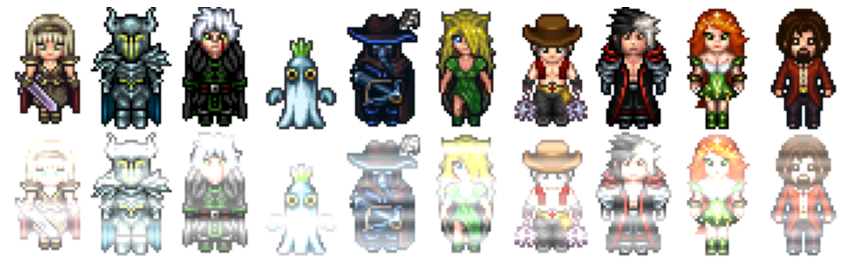

In [20]:
noise_ = generate_perlin_noise(dataset.shape, scale=5.0, octaves=1, persistence=0.3, lacunarity=1.0)
low_noise_data = dataset + noise_
plt.figure(figsize=(15, 10))
plt.imshow(get_sample(dataset, low_noise_data))
plt.axis('off')

In [13]:
def random_noise(image, n):
  alpha_indices = np.where(image[...,-1]==1.0)
  height_space = alpha_indices[0]
  width_space = alpha_indices[1]

  max_size = 5
  image = np.copy(image)

  height = image.shape[0]
  width = image.shape[1]
  h = 1
  w = 1

  try:
    from_ = np.random.choice(len(alpha_indices[0]), size=n)
  except:
    return image
  to = np.random.choice(len(alpha_indices[0]), size=n)
  from_y1 = height_space[from_]
  from_x1 = width_space[from_]
  to_y1 = height_space[to]
  to_x1 = width_space[to]

  minus = np.random.choice([-1,1], size=n)
  hs = np.full((n,), h)
  ws = np.full((n,), w)
  hs *= minus
  ws *= minus
  from_y2 = np.clip(from_y1 + hs, 0, height)
  from_x2 = np.clip(from_x1 + ws, 0, width)
  to_y2 = np.clip(to_y1 + hs, 0, height)
  to_x2 = np.clip(to_x1 + ws, 0, width)

  for fy1, fy2, fx1, fx2, ty1, ty2, tx1, tx2 in zip(from_y1, from_y2, from_x1, from_x2, to_y1, to_y2, to_x1, to_x2):       
      image[ty1:ty2, tx1:tx2, :] = (image[ty1:ty2, tx1:tx2, :] + image[fy1:fy2, fx1:fx2, :])/2

  return image

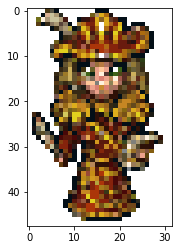

In [19]:
image = dataset[14]
show(random_noise(image, 1000)[...,:-1])

In [21]:
def blur(image, radius):
  data = np.clip(((image+1.0)*127.5), 0, 255).astype(np.uint8)
  image = Image.fromarray(data)
  blurred = image.filter(ImageFilter.GaussianBlur(radius=radius))
  blurred = np.array(blurred)
  blurred = blurred/127.5 - 1.0
  return blurred 

In [23]:
def add_normal_noise(image, loc, scale):
  noise = np.random.normal(loc=loc, scale=scale, size=image.shape)
  noisy_image = image + noise
  return image

(-0.5, 319.5, 95.5, -0.5)

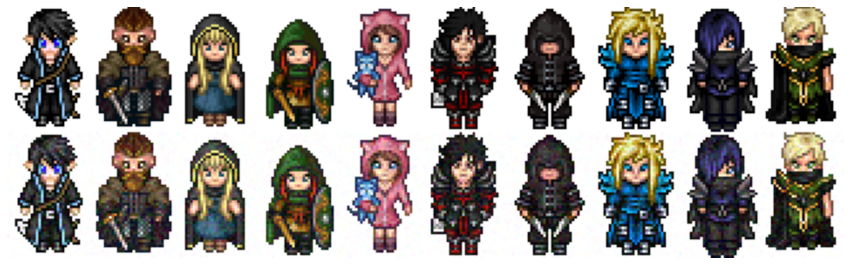

In [22]:
noise = np.random.normal(loc=0.1, scale=0.1, size=dataset.shape) #0.3, 0.22
noisy_dataset = dataset + noise
plt.figure(figsize=(15, 10))
plt.imshow(get_sample(dataset, noisy_dataset, size=10))
plt.axis('off')

In [24]:
#shows how the pictures look after selected transformations
def make_preview(dataset, generated=None):
  noisy_dataset = np.copy(dataset)
  for p in preprocessing:
    func = p[0]
    print(func)
    for i in range(len(dataset)):
      noisy_dataset[i] = func(noisy_dataset[i], **p[1])
  dataset = dataset if generated is None else generated
  dataset = dataset if dataset.shape[-1] == 3 else dataset[...,:-1]
  noisy_dataset = noisy_dataset if noisy_dataset.shape[-1] == 3 else noisy_dataset[...,:-1]
  samples = get_sample(dataset, noisy_dataset)
  plt.figure(figsize=(13,8), dpi=110)
  plt.imshow(samples)

<function random_noise at 0x7f30b9cea3b0>
<function blur at 0x7f30b9a014d0>
<function add_normal_noise at 0x7f30b81dd5f0>


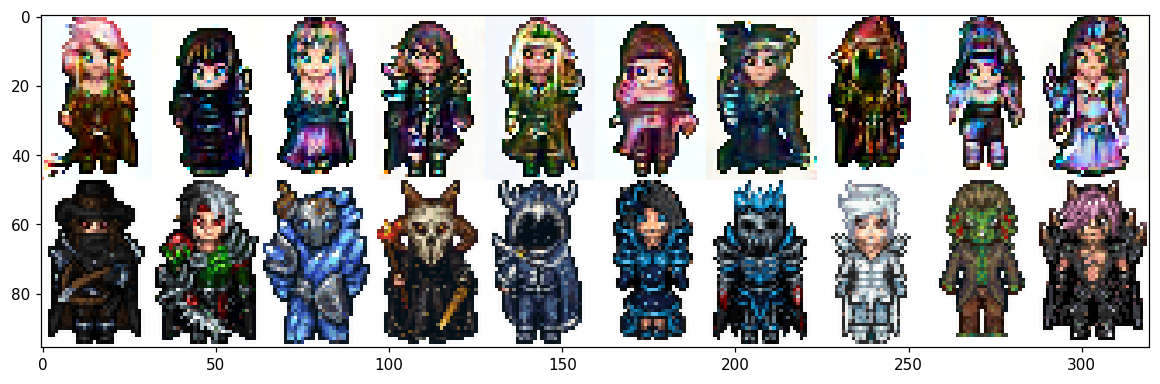

In [25]:
n = 500

preprocessing = [
                 [random_noise, {
                     'n' : 500
                 }],
                 [blur, {
                     'radius' : 0.2
                 }],
                 [add_normal_noise, {
                     'loc' : 0.1,
                     'scale' : 0.1
                 }]
]
make_preview(dataset[:n], generated_dataset)

# Heatmaps

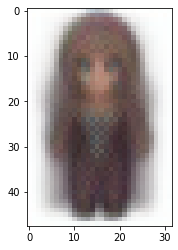

In [9]:
generated_mean = np.mean(generated_dataset, axis=0)
show(generated_mean)

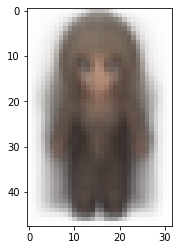

In [10]:
dataset_mean = np.mean(dataset[...,:-1], axis=0)
show(dataset_mean)

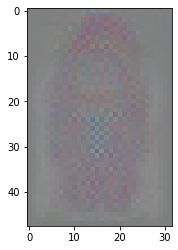

In [12]:
diff = generated_mean - dataset_mean
show(diff)

# Autoencoder

In [26]:
train, test = train_test_split(dataset, test_size=0.2,
	random_state=42)

In [74]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
      # initialize the input shape to be "channels last" along with
      # the channels dimension itself
      # channels dimension itself
      inputShape = (height, width, depth)
      chanDim = -1

    # define the input to the encoder
      inputs = Input(shape=inputShape)
      x = inputs
      # loop over the number of filters
      for f in filters:
          # apply a CONV => RELU => BN operation
          x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
          x = LeakyReLU(alpha=0.2)(x)
          x = BatchNormalization(axis=chanDim)(x)
      # flatten the network and then construct our latent vector
      volumeSize = K.int_shape(x)
      x = Flatten()(x)
      print(K.int_shape(x))
      latent = Dense(latentDim)(x)
      # build the encoder model
      encoder = Model(inputs, latent, name="encoder")

      # start building the decoder model which will accept the
      # output of the encoder as its inputs
      latentInputs = Input(shape=(latentDim,))
      x = Dense(np.prod(volumeSize[1:]))(latentInputs)
      x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
      # loop over our number of filters again, but this time in
      # reverse order
      for f in filters[::-1]:
          # apply a CONV_TRANSPOSE => RELU => BN operation
          x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
          x = LeakyReLU(alpha=0.2)(x)
          x = BatchNormalization(axis=chanDim)(x)
          
      #apply a single CONV_TRANSPOSE layer used to recover the
      # original depth of the image
      x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
      outputs = Activation("tanh")(x)
      # build the decoder model
      decoder = Model(latentInputs, outputs, name="decoder")
      # our autoencoder is the encoder + decoder
      autoencoder = Model(inputs, decoder(encoder(inputs)),
                          name="autoencoder")
      # return a 3-tuple of the encoder, decoder, and autoencoder
      return (encoder, decoder, autoencoder)

In [28]:
def preprocess(image):
  image = random_noise(image, n=500)
  image = blur(image, radius=0.2)
  image = add_normal_noise(image, loc=0.1, scale=0.1)
  return image

In [38]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    validation_split=0.2)

In [77]:
init_lr = 1.5e-4
epochs = 20
batch_size = 32

In [78]:
train_gen = gen.flow(
x=train,
y=train,
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True)

valid_gen = gen.flow(
x=train,
y=train,
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True)

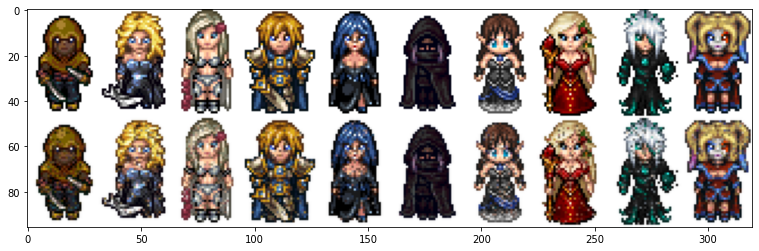

In [79]:
g = generate_data(train_gen)
train_data = next(g)
trainX = train_data[0]
trainY = train_data[1]
preview = get_sample(trainY, trainX)
plt.figure(figsize=(13,8))
plt.imshow(preview)

In [80]:
step_size_train = train_gen.n//batch_size
step_size_valid = valid_gen.n//batch_size

In [43]:
def generate_data(gen):
  while True:
    data = gen.next()
    x = data[0]
    y = data[1]
    yield (x[...,:-1], y[...,:-1])

In [89]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
encoder, decoder, autoencoder = ConvAutoencoder.build(32, 48, 3, filters=(64, 128), latentDim=4000)
#encoder, decoder, autoencoder = build_autoencoder(trainX[0].shape, 1000)
#opt = Adam(lr=init_lr, decay=init_lr/epochs)
opt = Adam(lr=init_lr)
autoencoder.compile(loss="mse", optimizer=opt, metrics=['mse'])
# train the convolutional autoencoder
H = autoencoder.fit(
  generate_data(train_gen),
	validation_data=generate_data(valid_gen),
  steps_per_epoch=step_size_train,
  validation_steps=step_size_valid,
	epochs=epochs,
	batch_size=batch_size)

[INFO] building autoencoder...
(None, 12288)
Epoch 1/20
76/76 [==============================] - 13s 165ms/step - loss: 0.4493 - mse: 0.4493 - val_loss: 0.5483 - val_mse: 0.5483
Epoch 2/20
76/76 [==============================] - 12s 163ms/step - loss: 0.2079 - mse: 0.2079 - val_loss: 0.5131 - val_mse: 0.5131
Epoch 3/20
76/76 [==============================] - 12s 163ms/step - loss: 0.1479 - mse: 0.1479 - val_loss: 0.3953 - val_mse: 0.3953
Epoch 4/20
76/76 [==============================] - 12s 166ms/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.2500 - val_mse: 0.2500
Epoch 5/20
76/76 [==============================] - 12s 163ms/step - loss: 0.0822 - mse: 0.0822 - val_loss: 0.1423 - val_mse: 0.1423
Epoch 6/20
76/76 [==============================] - 13s 168ms/step - loss: 0.0656 - mse: 0.0656 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 7/20
76/76 [==============================] - 12s 165ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0897 - val_mse: 0.0897
Epoch 8/20
76/76 [======

In [ ]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    inputs = Input(shape=img_shape)
    x = inputs
    x = Flatten()(x)
    #x = Dropout(0.001)(x)
    latent = Dense(code_size)(x)
    encoder = Model(inputs, latent, name="encoder")

    # The decoder
    latentInputs = Input(shape=(code_size,))
    x = Dense(np.prod(img_shape))(latentInputs)
    #x = Dropout(0.001)(x)
    x = Reshape(img_shape)(x)
    decoder = Model(latentInputs, x, name="decoder")

    autoencoder = Model(inputs, decoder(encoder(inputs)),
                          name="autoencoder")

    return encoder, decoder, autoencoder

### Train set

(-0.5, 319.5, 95.5, -0.5)

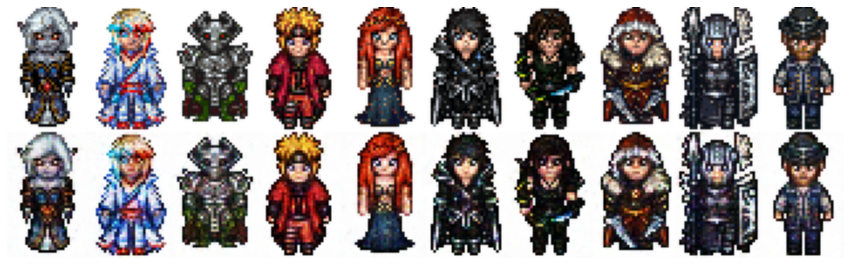

In [90]:
train_noisy = train_gen.next()[0]
train_decoded = autoencoder.predict(train_noisy[...,:-1])
plt.figure(figsize=(15, 10))
plt.imshow(get_sample(train_noisy[...,:-1], train_decoded, size=10))
plt.axis('off')

### Test set

(767, 48, 32, 4)


(-0.5, 319.5, 95.5, -0.5)

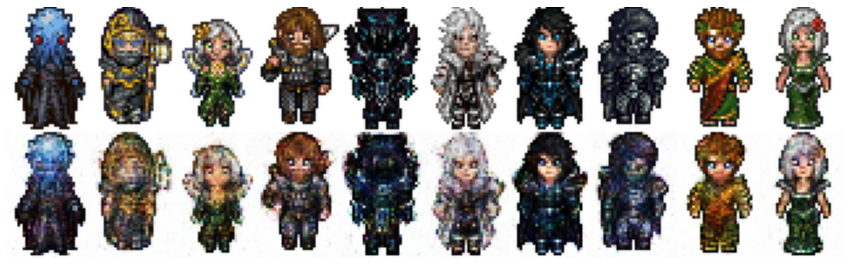

In [91]:
test_noisy = np.array([preprocess(test[i]) for i in range(len(test))])
print(test_noisy.shape)
test_decoded = autoencoder.predict(test_noisy[...,:-1])
plt.figure(figsize=(15, 10))
plt.imshow(get_sample(test_noisy[...,:-1], test_decoded, size=10))
plt.axis('off')

### Generated

(-0.5, 319.5, 95.5, -0.5)

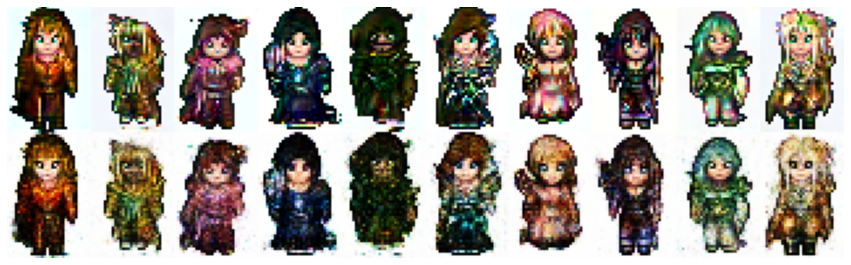

In [92]:
decoded = autoencoder.predict(generated_dataset[:500])
plt.figure(figsize=(15, 10))
plt.imshow(get_sample(generated_dataset[:500], decoded, size=10))
plt.axis('off')